In [2]:
!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, sin, cos, atan2, sqrt
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
from pandas import to_datetime

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn import neighbors
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import lightgbm as ltb

pd.set_option("display.max_columns", None)

In [4]:
def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2):
    R = 6371
    dLat = np.deg2rad(lat2-lat1)
    dLon = np.deg2rad(lon2-lon1)
    a = (sin(dLat/2)**2) + (cos(np.deg2rad(lat1)) * cos(np.deg2rad(lat2)) * (sin(dLon/2)**2))
    c = 2* atan2(sqrt(a), sqrt(1-a))
    d = R*c
    return d

### Loading Data...

In [140]:
customer_dataset = pd.read_csv("olist_customers_dataset.csv")
geolocation_dataset = pd.read_csv("olist_geolocation_dataset.csv")
order_items_dataset = pd.read_csv("olist_order_items_dataset.csv")
order_payments_dataset = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv")
orders_dataset = pd.read_csv("olist_orders_dataset.csv")
products_dataset = pd.read_csv("olist_products_dataset.csv")
sellers_dataset = pd.read_csv("olist_sellers_dataset.csv")
prod_category_name_translation_dataset = pd.read_csv("product_category_name_translation.csv")

## Exploratory Data Analysis

### Customer Data

In [6]:
print(customer_dataset.isna().any())
customer_dataset.head()

customer_id                 False
customer_unique_id          False
customer_zip_code_prefix    False
customer_city               False
customer_state              False
dtype: bool


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [7]:
print(geolocation_dataset.isna().any())
geolocation_dataset.head()

geolocation_zip_code_prefix    False
geolocation_lat                False
geolocation_lng                False
geolocation_city               False
geolocation_state              False
dtype: bool


geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [8]:
geo = geolocation_dataset.groupby('geolocation_zip_code_prefix').mean().reset_index()
geo.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                         1001       -23.550190       -46.634024
1                         1002       -23.548146       -46.634979
2                         1003       -23.548994       -46.635731
3                         1004       -23.549799       -46.634757
4                         1005       -23.549456       -46.636733

In [9]:
customer_loc_df = pd.merge(customer_dataset, geo, left_on = 'customer_zip_code_prefix', right_on = 'geolocation_zip_code_prefix').drop(columns= 'geolocation_zip_code_prefix')
customer_loc_df.rename(columns={'geolocation_lat': 'cust_lat', 'geolocation_lng': 'cust_lng'}, inplace=True)
print(customer_loc_df.isna().any())
customer_loc_df.head()

customer_id                 False
customer_unique_id          False
customer_zip_code_prefix    False
customer_city               False
customer_state              False
cust_lat                    False
cust_lng                    False
dtype: bool


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  5dca924cc99eea2dc5ba40d11ec5dd0f  2761fee7f378f0a8d7682d8a3fa07ab1   
2  661897d4968f1b59bfff74c7eb2eb4fc  d06a495406b79cb8203ea21cc0942f8c   
3  702b62324327ccba20f1be3465426437  8b3d988f330c1d1c3332ccd440c147b7   
4  bdf997bae7ca819b0415f5174d6b4302  866755e25db620f8d7e81b351a15bb2f   

   customer_zip_code_prefix customer_city customer_state   cust_lat   cust_lng  
0                     14409        franca             SP -20.498489 -47.396929  
1                     14409        franca             SP -20.498489 -47.396929  
2                     14409        franca             SP -20.498489 -47.396929  
3                     14409        franca             SP -20.498489 -47.396929  
4                     14409        franca             SP -20.498489 -47.396929

### Seller Data

In [10]:
print(sellers_dataset.isna().any())
sellers_dataset.head()

seller_id                 False
seller_zip_code_prefix    False
seller_city               False
seller_state              False
dtype: bool


seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

In [11]:
seller_loc_df = pd.merge(sellers_dataset, geo, left_on = 'seller_zip_code_prefix', right_on = 'geolocation_zip_code_prefix').drop(columns = 'geolocation_zip_code_prefix') 
seller_loc_df.rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'}, inplace=True)
seller_loc_df.head()

seller_id  seller_zip_code_prefix     seller_city  \
0  3442f8959a84dea7ee197c632cb2df15                   13023        campinas   
1  e0eabded302882513ced4ea3eb0c7059                   13023        campinas   
2  d1b65fc7debc3361ea86b5f14c68d2e2                   13844      mogi guacu   
3  ce3ad9de960102d0677a81f5d0bb7b2d                   20031  rio de janeiro   
4  1d2732ef8321502ee8488e8bed1ab8cd                   20031  rio de janeiro   

  seller_state  seller_lat  seller_lng  
0           SP  -22.893848  -47.061337  
1           SP  -22.893848  -47.061337  
2           SP  -22.383437  -46.947927  
3           RJ  -22.909572  -43.177703  
4           RJ  -22.909572  -43.177703

### Order Data

In [12]:
print(order_items_dataset.isna().any())
order_items_dataset.head()

order_id               False
order_item_id          False
product_id             False
seller_id              False
shipping_limit_date    False
price                  False
freight_value          False
dtype: bool


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

#### Calculating each order total value i-e total price + total freight value

In [13]:
order_items_value = order_items_dataset.groupby(['order_id','product_id','seller_id']).agg(
    tot_price=('price', 'sum'), tot_freight_val=('freight_value', 'sum'), no_of_items=('order_item_id', 'count'),).reset_index()
order_items_value['tot_order_val'] = order_items_value['tot_price'] + order_items_value['tot_freight_val']
order_items_value.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id  tot_price  tot_freight_val  no_of_items  \
0  48436dade18ac8b2bce089ec2a041202      58.90            13.29            1   
1  dd7ddc04e1b6c2c614352b383efe2d36     239.90            19.93            1   
2  5b51032eddd242adc84c38acab88f23d     199.00            17.87            1   
3  9d7a1d34a5052409006425275ba1c2b4      12.99            12.79            1   
4  df560393f3a51e74553ab94004ba5c87     199.90            18.14            1   

   tot_order_val  
0          72.19  
1         259.83  
2         216.87  
3          25.78  
4         218.04

In [14]:
print(orders_dataset.isna().any())
orders_dataset.head()

order_id                         False
customer_id                      False
order_status                     False
order_purchase_timestamp         False
order_approved_at                 True
order_delivered_carrier_date      True
order_delivered_customer_date     True
order_estimated_delivery_date    False
dtype: bool


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

### Products Data

In [15]:
products_dataset.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

#### Calculating each product volume

In [17]:
products_dataset['product_volume_cm3']=products_dataset.product_length_cm * products_dataset.product_height_cm * products_dataset.product_width_cm
products_dataset.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             225.0               16.0               10.0              14.0   
1            1000.0               30.0               18.0              20.0   
2             154.0               18.0                9.0              15.0   
3             371.0               26.0                4.0              26.0   
4             625.0               20.0               17.0              13.0   

   product_volume_cm3  
0              2240.0  
1             10800.0  
2              2430.0  
3              2704.0  
4              4420.0

#### For predicting shipment time we will take for our training dataset only those orders which were successfully delivered 

In [18]:
delivered_orders = orders_dataset[orders_dataset.order_status == 'delivered']
print("Is there any Nan values: \n")
print(delivered_orders.isna().any())
delivered_orders.head()

Is there any Nan values: 

order_id                         False
customer_id                      False
order_status                     False
order_purchase_timestamp         False
order_approved_at                 True
order_delivered_carrier_date      True
order_delivered_customer_date     True
order_estimated_delivery_date    False
dtype: bool


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

#### Very few orders have missing carrier or delivery dates, hence will simply drop these records

In [19]:
print("Carrier date having null values count: " + str(delivered_orders['order_delivered_carrier_date'].isna().sum()))
print("Order delivered date having null values count: " + str(delivered_orders['order_delivered_customer_date'].isna().sum()))

Carrier date having null values count: 2
Order delivered date having null values count: 8


In [20]:
delivered_orders = delivered_orders.dropna()

### Finalizing training dataset merging data from orders, customers, seller, products and order_items datasets

In [130]:
merged_df = pd.merge(delivered_orders, order_items_value, how = 'left', left_on = 'order_id', right_on = 'order_id')
merged_df = pd.merge(merged_df,customer_loc_df[['customer_id', 'customer_city', 'customer_state','cust_lat','cust_lng']], left_on = 'customer_id', right_on='customer_id')
merged_df = pd.merge(merged_df,seller_loc_df[['seller_id', 'seller_city', 'seller_state','seller_lat','seller_lng']], left_on = 'seller_id', right_on='seller_id')
merged_df = pd.merge(merged_df,products_dataset[['product_id', 'product_volume_cm3', 'product_weight_g']], left_on = 'product_id', right_on='product_id')
merged_df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
2  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
3  bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
4  8736140c61ea584cb4250074756d8f3b  ab8844663ae049fda8baf15fc928f47f   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
2    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   
3    delivered      2017-10-23 23:26:46  2017-10-25 02:14:11   
4    delivered      2017-08-10 13:35:55  2017-08-10 13:50:09   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-08-17 15:28:33           2017-08-18 14:44:43   
2          2017-08-04 17:35:43           2017-08-07 18:30:01   
3          2017-10-27 16:48:46           2017-11-07 18:04:59   
4          2017-08-11 13:52:35           2017-08-16 19:03:36   

  order_estimated_delivery_date                        product_id  \
0           2017-10-18 00:00:00  87285b34884572647811a353c7ac498a   
1           2017-08-28 00:00:00  87285b34884572647811a353c7ac498a   
2           2017-08-15 00:00:00  87285b34884572647811a353c7ac498a   
3           2017-11-13 00:00:00  87285b34884572647811a353c7ac498a   
4           2017-08-23 00:00:00  b00a32a0b42fd65efb58a5822009f629   

                          seller_id  tot_price  tot_freight_val  no_of_items  \
0  3504c0cb71d7fa48d967e0e4c94d59d9      29.99             8.72            1   
1  3504c0cb71d7fa48d967e0e4c94d59d9      29.99             7.78            1   
2  3504c0cb71d7fa48d967e0e4c94d59d9      29.99             7.78            1   
3  3504c0cb71d7fa48d967e0e4c94d59d9      29.99            14.10            1   
4  3504c0cb71d7fa48d967e0e4c94d59d9      75.90             7.79            1   

   tot_order_val    customer_city customer_state   cust_lat   cust_lng  \
0          38.71        sao paulo             SP -23.576983 -46.587161   
1          37.77        sao paulo             SP -23.564630 -46.534268   
2          37.77        sao paulo             SP -23.600462 -46.655318   
3          44.09    florianopolis             SC -27.528367 -48.491914   
4          83.69  itaquaquecetuba             SP -23.486111 -46.366721   

  seller_city seller_state  seller_lat  seller_lng  product_volume_cm3  \
0        maua           SP  -23.680729  -46.444238              1976.0   
1        maua           SP  -23.680729  -46.444238              1976.0   
2        maua           SP  -23.680729  -46.444238              1976.0   
3        maua           SP  -23.680729  -46.444238              1976.0   
4        maua           SP  -23.680729  -46.444238              3000.0   

   product_weight_g  
0             500.0  
1             500.0  
2             500.0  
3             500.0  
4             238.0

### Engineering new features

In [131]:
merged_df.order_delivered_customer_date = pd.to_datetime(merged_df.order_delivered_customer_date)
merged_df.order_delivered_carrier_date = pd.to_datetime(merged_df.order_delivered_carrier_date)
merged_df.order_purchase_timestamp = pd.to_datetime(merged_df.order_purchase_timestamp)
merged_df.order_estimated_delivery_date = pd.to_datetime(merged_df.order_estimated_delivery_date)

#### Boolean feature to suggest if order being delivered in same city or state, hypothesis is if customer is in a different city or state then it will take more time for shipment

In [132]:
merged_df['is_same_city'] = np.where(merged_df["customer_city"] == merged_df["seller_city"], 1, 0)
merged_df['is_same_state'] = np.where(merged_df["customer_state"] == merged_df["seller_state"], 1, 0)

#### Determining month and day of week to give model some information regarding seasonality and weekend vs weekdays trend if there any in the dataset

In [133]:
merged_df['purchase_month']=merged_df.order_purchase_timestamp.dt.month
merged_df['purchase_day_of_week']=merged_df.order_purchase_timestamp.dt.dayofweek
merged_df['is_weekend'] = np.where((merged_df["purchase_day_of_week"] == 5) | (merged_df["purchase_day_of_week"] == 6), 1, 0)

#### Calculating estimated delivery days

In [134]:
merged_df['estimated_delivery_days'] = abs((merged_df.order_estimated_delivery_date-merged_df.order_purchase_timestamp).dt.days)

#### Calculating distance between seller and customer location. Hypothesis is more distance there is longer it would take the shipment to get delivered.

In [135]:
merged_df['distance'] = merged_df.apply(
    lambda row: getDistanceFromLatLonInKm(
        row['seller_lat'],
        row['seller_lng'],
        row['cust_lat'],
        row['cust_lng'],
    ),
    axis=1,
)

#### Calculating target variable that is shipment time in days for historical data. Making an assumption that it will be the time difference between the date order being handed over to logistic partner and the date it was actually being delivered to customer.

In [136]:
merged_df['shipment_time_days'] = (merged_df.order_delivered_customer_date-merged_df.order_delivered_carrier_date).dt.days

In [137]:
merged_df['shipment_time_days'].describe()

count    99679.000000
mean         8.812318
std          8.726562
min        -17.000000
25%          4.000000
50%          7.000000
75%         11.000000
max        205.000000
Name: shipment_time_days, dtype: float64

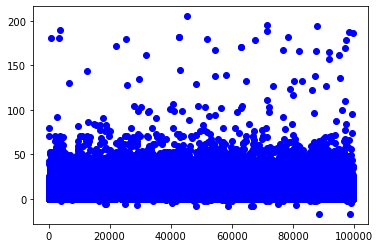

In [138]:
plt.plot(merged_df.index, merged_df.shipment_time_days, 'bo')

#### Some records have delivery dates earlier then the carrier handing over date. Removing such records as they are probably wrongly populated. Also 99.6% of the shipment days are within 50, hence removing outliers from data where shipment days are above 50.

In [78]:
merged_df[(merged_df.shipment_time_days >= 0) & (merged_df.shipment_time_days <= 50)]['shipment_time_days'].describe()

count    99233.000000
mean         8.549122
std          7.342918
min          0.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         50.000000
Name: shipment_time_days, dtype: float64

In [79]:
merged_df = merged_df[(merged_df.shipment_time_days >= 0) & (merged_df.shipment_time_days <= 50)]

### Final engineered dataset

In [81]:
merged_df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
2  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
3  bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
4  8736140c61ea584cb4250074756d8f3b  ab8844663ae049fda8baf15fc928f47f   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
2    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   
3    delivered      2017-10-23 23:26:46  2017-10-25 02:14:11   
4    delivered      2017-08-10 13:35:55  2017-08-10 13:50:09   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-08-17 15:28:33           2017-08-18 14:44:43   
2          2017-08-04 17:35:43           2017-08-07 18:30:01   
3          2017-10-27 16:48:46           2017-11-07 18:04:59   
4          2017-08-11 13:52:35           2017-08-16 19:03:36   

  order_estimated_delivery_date                        product_id  \
0                    2017-10-18  87285b34884572647811a353c7ac498a   
1                    2017-08-28  87285b34884572647811a353c7ac498a   
2                    2017-08-15  87285b34884572647811a353c7ac498a   
3                    2017-11-13  87285b34884572647811a353c7ac498a   
4                    2017-08-23  b00a32a0b42fd65efb58a5822009f629   

                          seller_id  tot_price  tot_freight_val  no_of_items  \
0  3504c0cb71d7fa48d967e0e4c94d59d9      29.99             8.72            1   
1  3504c0cb71d7fa48d967e0e4c94d59d9      29.99             7.78            1   
2  3504c0cb71d7fa48d967e0e4c94d59d9      29.99             7.78            1   
3  3504c0cb71d7fa48d967e0e4c94d59d9      29.99            14.10            1   
4  3504c0cb71d7fa48d967e0e4c94d59d9      75.90             7.79            1   

   tot_order_val    customer_city customer_state   cust_lat   cust_lng  \
0          38.71        sao paulo             SP -23.576983 -46.587161   
1          37.77        sao paulo             SP -23.564630 -46.534268   
2          37.77        sao paulo             SP -23.600462 -46.655318   
3          44.09    florianopolis             SC -27.528367 -48.491914   
4          83.69  itaquaquecetuba             SP -23.486111 -46.366721   

  seller_city seller_state  seller_lat  seller_lng  product_volume_cm3  \
0        maua           SP  -23.680729  -46.444238              1976.0   
1        maua           SP  -23.680729  -46.444238              1976.0   
2        maua           SP  -23.680729  -46.444238              1976.0   
3        maua           SP  -23.680729  -46.444238              1976.0   
4        maua           SP  -23.680729  -46.444238              3000.0   

   product_weight_g  is_same_city  is_same_state  purchase_month  \
0             500.0             0              1              10   
1             500.0             0              1               8   
2             500.0             0              1               8   
3             500.0             0              0              10   
4             238.0             0              1               8   

   purchase_day_of_week  is_weekend  estimated_delivery_days    distance  \
0                     0           0                       15   18.576110   
1                     1           0                       12   15.836181   
2                     2           0                       12   23.280158   
3                     0           0                       20  474.529863   
4                     3           0                       12   23.037272   

   shipment_time_days  
0                   6  
1                   0  
2                   3  
3                  11  
4                   5

### Dropping attributes that are no longer required for the model to be trained on.

In [83]:
merged_df = merged_df.drop(['order_id','customer_id','order_status','order_delivered_carrier_date','order_delivered_customer_date',
                           'order_estimated_delivery_date','seller_id','customer_id','product_id','order_purchase_timestamp',
                           'order_approved_at'], axis=1)
merged_df = merged_df.dropna()
print(merged_df.isna().any())
merged_df.head()

tot_price                  False
tot_freight_val            False
no_of_items                False
tot_order_val              False
customer_city              False
customer_state             False
cust_lat                   False
cust_lng                   False
seller_city                False
seller_state               False
seller_lat                 False
seller_lng                 False
product_volume_cm3         False
product_weight_g           False
is_same_city               False
is_same_state              False
purchase_month             False
purchase_day_of_week       False
is_weekend                 False
estimated_delivery_days    False
distance                   False
shipment_time_days         False
dtype: bool


tot_price  tot_freight_val  no_of_items  tot_order_val    customer_city  \
0      29.99             8.72            1          38.71        sao paulo   
1      29.99             7.78            1          37.77        sao paulo   
2      29.99             7.78            1          37.77        sao paulo   
3      29.99            14.10            1          44.09    florianopolis   
4      75.90             7.79            1          83.69  itaquaquecetuba   

  customer_state   cust_lat   cust_lng seller_city seller_state  seller_lat  \
0             SP -23.576983 -46.587161        maua           SP  -23.680729   
1             SP -23.564630 -46.534268        maua           SP  -23.680729   
2             SP -23.600462 -46.655318        maua           SP  -23.680729   
3             SC -27.528367 -48.491914        maua           SP  -23.680729   
4             SP -23.486111 -46.366721        maua           SP  -23.680729   

   seller_lng  product_volume_cm3  product_weight_g  is_same_city  \
0  -46.444238              1976.0             500.0             0   
1  -46.444238              1976.0             500.0             0   
2  -46.444238              1976.0             500.0             0   
3  -46.444238              1976.0             500.0             0   
4  -46.444238              3000.0             238.0             0   

   is_same_state  purchase_month  purchase_day_of_week  is_weekend  \
0              1              10                     0           0   
1              1               8                     1           0   
2              1               8                     2           0   
3              0              10                     0           0   
4              1               8                     3           0   

   estimated_delivery_days    distance  shipment_time_days  
0                       15   18.576110                   6  
1                       12   15.836181                   0  
2                       12   23.280158                   3  
3                       20  474.529863                  11  
4                       12   23.037272                   5

#### Label Encoding Categorical columns

In [84]:
from sklearn.preprocessing import LabelEncoder
cols = list(set(merged_df.columns.to_list()) - set(merged_df._get_numeric_data().columns.to_list()))

merged_df[cols] = merged_df[cols].apply(LabelEncoder().fit_transform)

merged_df.head()

tot_price  tot_freight_val  no_of_items  tot_order_val  customer_city  \
0      29.99             8.72            1          38.71           3513   
1      29.99             7.78            1          37.77           3513   
2      29.99             7.78            1          37.77           3513   
3      29.99            14.10            1          44.09           1329   
4      75.90             7.79            1          83.69           1793   

   customer_state   cust_lat   cust_lng  seller_city  seller_state  \
0              25 -23.576983 -46.587161          321            21   
1              25 -23.564630 -46.534268          321            21   
2              25 -23.600462 -46.655318          321            21   
3              23 -27.528367 -48.491914          321            21   
4              25 -23.486111 -46.366721          321            21   

   seller_lat  seller_lng  product_volume_cm3  product_weight_g  is_same_city  \
0  -23.680729  -46.444238              1976.0             500.0             0   
1  -23.680729  -46.444238              1976.0             500.0             0   
2  -23.680729  -46.444238              1976.0             500.0             0   
3  -23.680729  -46.444238              1976.0             500.0             0   
4  -23.680729  -46.444238              3000.0             238.0             0   

   is_same_state  purchase_month  purchase_day_of_week  is_weekend  \
0              1              10                     0           0   
1              1               8                     1           0   
2              1               8                     2           0   
3              0              10                     0           0   
4              1               8                     3           0   

   estimated_delivery_days    distance  shipment_time_days  
0                       15   18.576110                   6  
1                       12   15.836181                   0  
2                       12   23.280158                   3  
3                       20  474.529863                  11  
4                       12   23.037272                   5

### Plotting heatmap to understand correlation of each feature with target variable and within themselves

Text(0.5, 1.0, 'Heatmap of Features')

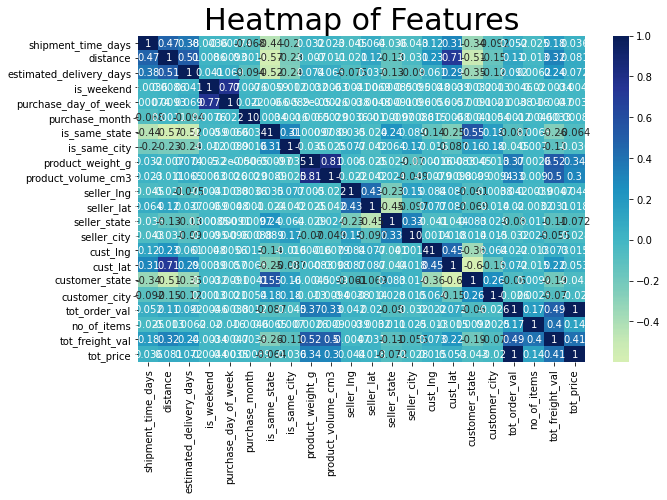

In [85]:
plt.figure(figsize=(10, 6))
sns.heatmap(merged_df[merged_df.columns[::-1]].corr(), cmap="YlGnBu", annot=True, center = 0, )
plt.title("Heatmap of Features", fontsize = 30)

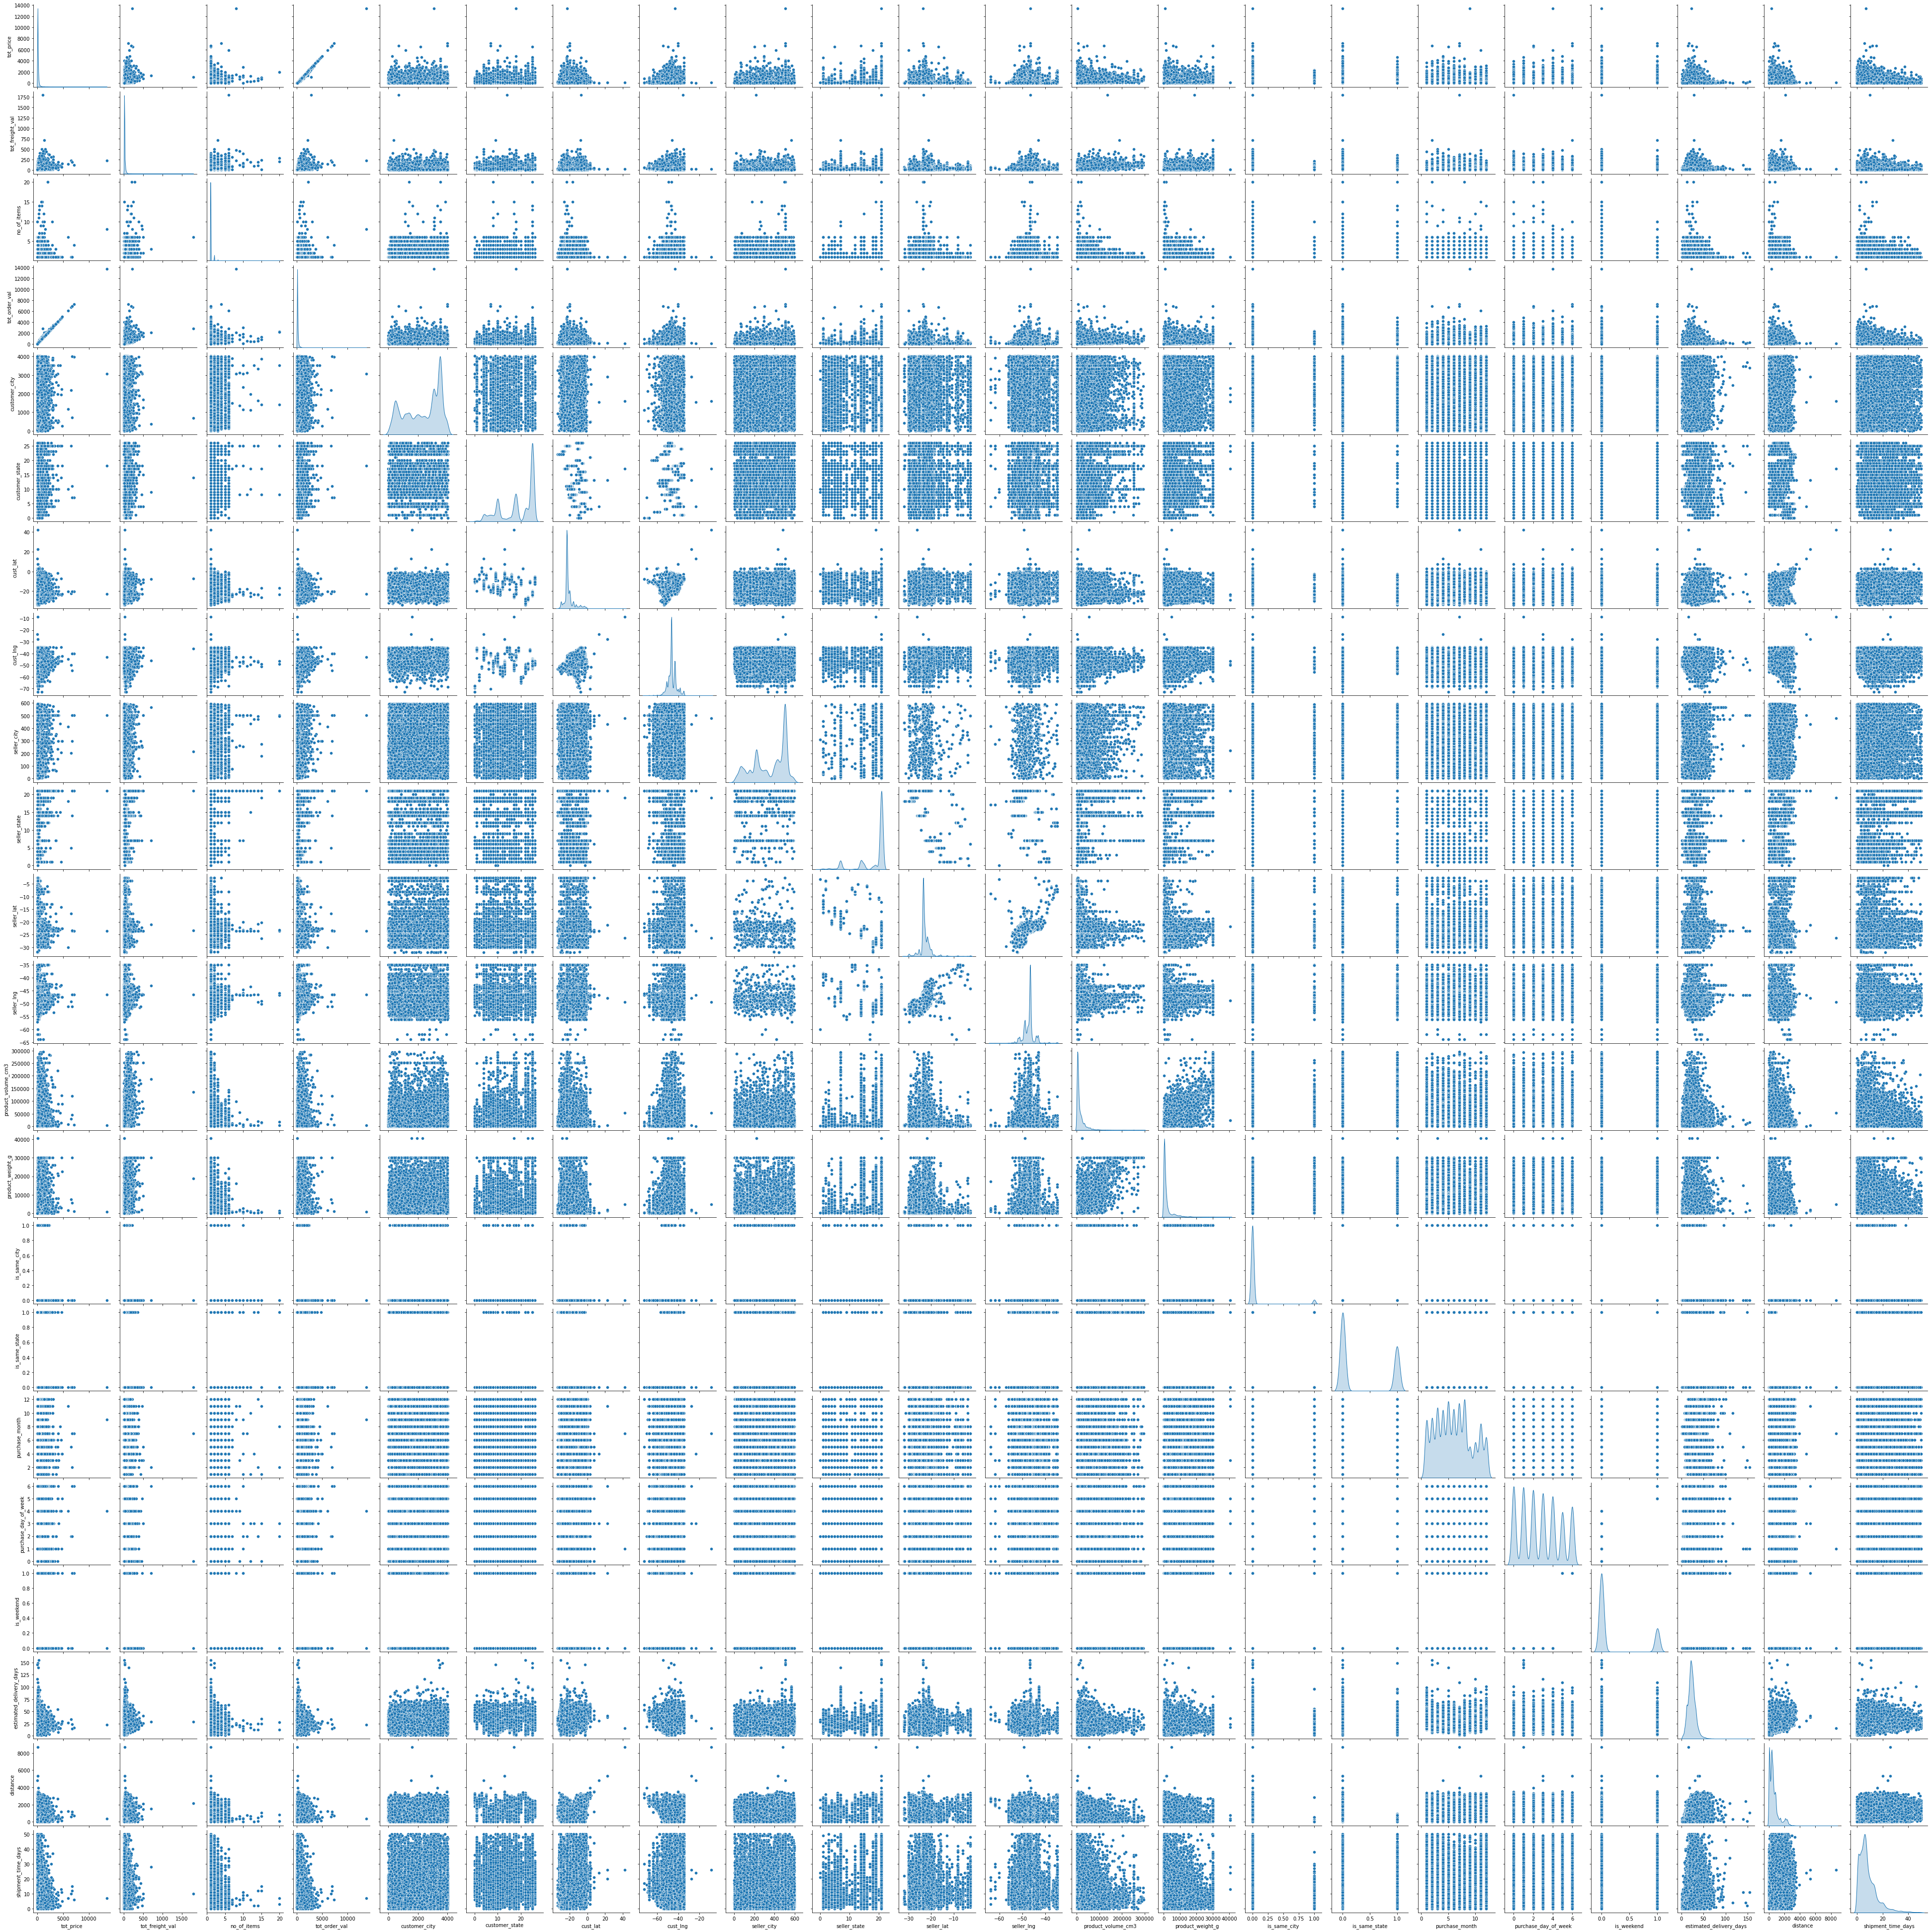

In [129]:
sns.pairplot(data=merged_df, diag_kind='kde')

### From the heatmap it is obvious that distance is highly correlated with shipment time. Other important features seems to be estimated_deliver_days and tot_freight_val.

### Going to train multiple regressor model for our dataset and evaluate using R2 score and mean squared error to determine which models perform best

In [98]:
target = 'shipment_time_days'
features = ['tot_freight_val', 
            'product_weight_g',
            'customer_state',
            'seller_state',
            'product_volume_cm3',
            'is_same_city', 
            'purchase_month', 
            'purchase_day_of_week',
            'estimated_delivery_days',
            'distance',
            'is_same_state',
            'is_weekend',
            'no_of_items'
           ]

X_data = merged_df[features]
y = merged_df[target]

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.25, random_state = 10)


models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['LightGBM ', ltb.LGBMRegressor()],
           ['RandomForest ',RandomForestRegressor()],
           ['LinearRegression :',LinearRegression()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()] ,
           ['XGBoost: ', XGBRegressor()] ,
         ]

model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 10
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = metrics.r2_score(y_train,curr_model.predict(X_train))
    curr_model_data["Test_R2_Score"] = metrics.r2_score(y_test,curr_model.predict(X_test))
    curr_model_data["Test_RMSE"] = sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))/100
    model_data.append(curr_model_data)

### From the evaluations it can be observed that LightGBM is the best regression model for our dataset

In [89]:
model_scores = pd.DataFrame(model_data)
model_scores

Name  Train_Time  Train_R2_Score  Test_R2_Score  \
0                      Lasso:     0.071028        0.263022       0.264478   
1                      Ridge:     0.020335        0.293376       0.294577   
2        KNeighborsRegressor:     0.699740        0.428577       0.145651   
3                    LightGBM     0.701766        0.485169       0.442703   
4           LinearRegression :    0.057109        0.293376       0.294577   
5  GradientBoostingRegressor:    26.185629        0.415445       0.409928   
6                    XGBoost:    10.864173        0.574033       0.444004   

   Test_RMSE  
0   0.062937  
1   0.061636  
2   0.067831  
3   0.054784  
4   0.061636  
5   0.056372  
6   0.054720

### Using GridSearchCV to select the best hyper parameters for LGMRegressor

In [108]:
from sklearn.model_selection import GridSearchCV
model = ltb.LGBMRegressor()
grid_vals = {'n_estimators': [100,200,300], 'max_depth': [4,6,8], 'num_leaves':[100,200,300],'learning_rate':[0.01,0.1]}
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='neg_root_mean_squared_error', 
                       cv=6, refit=True, return_train_score=True) 

#Training and Prediction

grid_lr.fit(X_train, y_train)
preds = grid_lr.best_estimator_.predict(X_test)


In [113]:
print("LGBM's Mean Absolute Error: " + str(mean_absolute_error(preds, y_test)))
print("LGBM's Mean Squared Error: " + str(mean_squared_error(preds, y_test)))
print("LGBM's Root Mean Squared Error: " + str(np.sqrt(mean_squared_error(preds, y_test))/100))
print("LGBM's Best Params: " + str(grid_lr.best_params_))

LGBM's Mean Absolute Error: 3.667912729570375
LGBM's Mean Squared Error: 30.76790242008726
LGBM's Root Mean Squared Error: 0.05546882225186259
LGBM's Best Params: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'num_leaves': 300}


#### Feature importance from the LGBM is consistent with what we had observed using correlation heatmap and pairplot

In [116]:
import time
import numpy as np

start_time = time.time()
importances = grid_lr.best_estimator_.feature_importances_


In [128]:
LGBM_importances = pd.Series(importances, index=features)
print("Feature Importance")
LGBM_importances.sort_values(axis=0, ascending=False)

Feature Importance


distance                   2039
tot_freight_val            1825
product_volume_cm3         1618
estimated_delivery_days    1540
product_weight_g           1480
purchase_month             1417
customer_state             1133
purchase_day_of_week        586
seller_state                562
no_of_items                 122
is_same_state                55
is_same_city                 25
is_weekend                    0
dtype: int32

## Conclusion

1) The model accuracy is at an aceptable level. MAE of between 3-4 days suggesting that the model is within two-thirds of our target data's standard deviation, which in several situations is an acceptable level of accuracy.<br>
2) However, with more relevant information regarding the transportation medium being used for delivery, infrastructure, availability of flights, train or other modes in seller's location can help engineered features that would provide more useful information to model to make better estimation of delivery time.<br>
3) Limited data also effect model performance. More data would help model achieve higher level of accuracy.